In [40]:
import h5py
import time as t
import numpy as np
import matplotlib.pyplot as plt

In [41]:
def hdf2dict(file_name):
    # Define the dictionary to store the datasets
    data = {}
    #file_name = 'macro421_UO2_03__900K.h5'
    with h5py.File("..//02.Macro.XS.421g/" + file_name, "r") as file:
        # Iterate over the dataset names in the group
        for dataset_name in file.keys():
            # Read the dataset
            dataset = file[dataset_name]
            # Check if the dataset is a struct
            if isinstance(dataset, h5py.Group):
                # Create a dictionary to store the struct fields
                struct_data = {}
                # Iterate over the fields in the struct
                for field_name in dataset.keys():
                    # Read the field dataset
                    field_dataset = np.array(dataset[field_name])
                    # Store the field dataset in the struct dictionary
                    struct_data[field_name] = field_dataset
                # Store the struct data in the main data dictionary
                data[dataset_name] = struct_data
            else:
                # Read the dataset as a regular array
                dataset_array = np.array(dataset)
                # Store the dataset array in the dictionary
                data[dataset_name] = dataset_array

#print(data["SigC"])
    return data

#file_name = 'macro421_UO2_03__900K.h5'
#fuel = hdf2dict(file_name)
#fuel.keys()

File 'macro421_UO2_03__900K.h5' has been read in.
File 'macro421_Zry__600K.h5' has been read in.
File 'macro421_H2OB__600K.h5' has been read in.
Inactive cycle =   1/100; k-eff cycle = 1.02739; numNeutrons = 165
Inactive cycle =   2/100; k-eff cycle = 1.08796; numNeutrons = 118
Inactive cycle =   3/100; k-eff cycle = 1.00144; numNeutrons = 101
Inactive cycle =   4/100; k-eff cycle = 0.99266; numNeutrons =  98
Inactive cycle =   5/100; k-eff cycle = 1.02152; numNeutrons = 103
Inactive cycle =   6/100; k-eff cycle = 1.14339; numNeutrons = 113
Inactive cycle =   7/100; k-eff cycle = 1.08108; numNeutrons = 112
Inactive cycle =   8/100; k-eff cycle = 1.16987; numNeutrons = 121
Inactive cycle =   9/100; k-eff cycle = 1.18762; numNeutrons = 123
Inactive cycle =  10/100; k-eff cycle = 1.26513; numNeutrons = 129
Inactive cycle =  11/100; k-eff cycle = 0.98816; numNeutrons = 108
Inactive cycle =  12/100; k-eff cycle = 0.96762; numNeutrons =  98
Inactive cycle =  13/100; k-eff cycle = 1.02767; nu

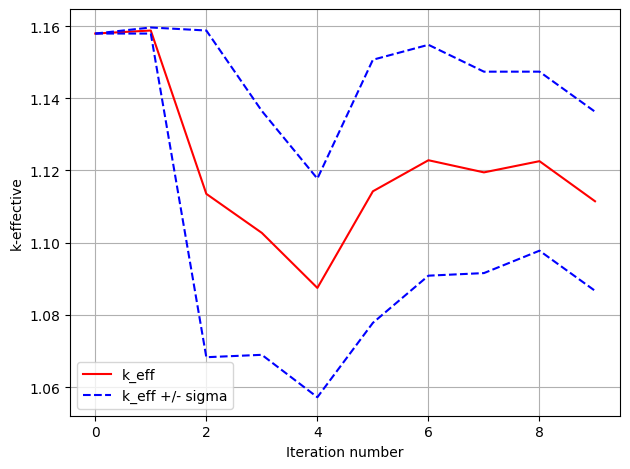

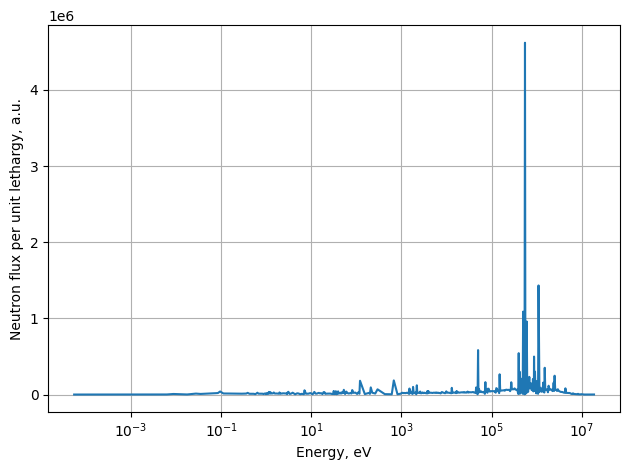

In [42]:
# Start the timer
start_time = t.time()

#--------------------------------------------------------------------------
# Number of source neutrons
numNeutrons_born = 100      # INPUT

# Number of inactive source cycles to skip before starting k-eff accumulation
numCycles_inactive = 100    # INPUT

# Number of active source cycles for k-eff accumulation
numCycles_active = 10     # INPUT

# Size of the square unit cell
pitch = 3.6  # cm           # INPUT

#--------------------------------------------------------------------------
# Path to macroscopic cross section data:
# (Assuming the corresponding data files are available and accessible)
macro_xs_path = '..//02.Macro.XS.421g'

# Fill the structures fuel, clad, and cool with the cross-section data
fuel = hdf2dict('macro421_UO2_03__900K.h5')  # INPUT
print(f"File 'macro421_UO2_03__900K.h5' has been read in.")
clad = hdf2dict('macro421_Zry__600K.h5')     # INPUT
print(f"File 'macro421_Zry__600K.h5' has been read in.")
cool  = hdf2dict('macro421_H2OB__600K.h5')   # INPUT
print(f"File 'macro421_H2OB__600K.h5' has been read in.")

# Define the majorant: the maximum total cross-section vector
SigTmax = np.max(np.vstack((fuel["SigT"], clad["SigT"], cool["SigT"])), axis=0)

# Number of energy groups
ng = fuel['ng']

#--------------------------------------------------------------------------
# Detectors
detectS = np.zeros(ng)

#--------------------------------------------------------------------------
# Four main vectors describing the neutrons in a batch
x = np.zeros(numNeutrons_born * 2)
y = np.zeros(numNeutrons_born * 2)
weight = np.ones(numNeutrons_born * 2)
iGroup = np.ones(numNeutrons_born * 2, dtype=int)

#--------------------------------------------------------------------------
# Neutrons are assumed born randomly distributed in the cell with weight 1
# with sampled fission energy spectrum
numNeutrons = numNeutrons_born
for iNeutron in range(numNeutrons):
    x[iNeutron] = np.random.rand() * pitch
    y[iNeutron] = np.random.rand() * pitch
    weight[iNeutron] = 1
    # Sample the neutron energy group
    iGroup[iNeutron] = np.argmax(np.cumsum(fuel['chi']) >= np.random.rand()) - 1
    #print(f"iNeutron: {iNeutron}, iGroup[iNeutron]: {iGroup[iNeutron]}")

#--------------------------------------------------------------------------
# Prepare vectors for keff and standard deviation of keff
keff_expected = np.ones(numCycles_active)
sigma_keff = np.zeros(numCycles_active)
keff_active_cycle = np.ones(numCycles_active)
virtualCollision = False

# Main (power) iteration loop
for iCycle in range(1, numCycles_inactive + numCycles_active + 1):

    # Normalize the weights of the neutrons to make the total weight equal to
    # numNeutrons_born (equivalent to division by keff_cycle)
    weight = (weight / np.sum(weight, axis=0, keepdims=True)) * numNeutrons_born
    weight0 = weight.copy()

    #----------------------------------------------------------------------
    # Loop over neutrons
    for iNeutron in range(numNeutrons):

        absorbed = False

        #------------------------------------------------------------------
        # Neutron random walk cycle: from emission to absorption

        while not absorbed:

            # Sample free path length according to the Woodcock method
            #print("iNeutron:", iNeutron)
            #print("iGroup[iNeutron]:", iGroup[iNeutron])
            freePath = -np.log(np.random.rand()) / SigTmax[iGroup[iNeutron]]

            if not virtualCollision:
                # Sample the direction of neutron flight assuming both
                # fission and scattering are isotropic in the lab (a strong
                # assumption!)
                teta = np.pi * np.random.rand()
                phi = 2.0 * np.pi * np.random.rand()
                dirX = np.sin(teta) * np.cos(phi)
                dirY = np.sin(teta) * np.sin(phi)

            # Fly
            x[iNeutron] += freePath * dirX
            y[iNeutron] += freePath * dirY

            # If outside the cell, find the corresponding point inside the
            # cell
            while x[iNeutron] < 0:
                x[iNeutron] += pitch
            while y[iNeutron] < 0:
                y[iNeutron] += pitch
            while x[iNeutron] > pitch:
                x[iNeutron] -= pitch
            while y[iNeutron] > pitch:
                y[iNeutron] -= pitch

            # Find the total and scattering cross sections
            if 0.9 < x[iNeutron] < 2.7:  # INPUT
                SigA = fuel['SigF'][iGroup[iNeutron]] + fuel['SigC'][iGroup[iNeutron]] + fuel['SigL'][iGroup[iNeutron]]
                SigS = fuel["sigS_G"]["sparse_SigS[0]"][iGroup[iNeutron], :].reshape(-1, 1)
                SigP = fuel['SigP'][0, iGroup[iNeutron]]
            elif x[iNeutron] < 0.7 or x[iNeutron] > 2.9:  # INPUT
                SigA = cool['SigC'][iGroup[iNeutron]] + cool['SigL'][iGroup[iNeutron]]
                SigS = cool["sigS_G"]["sparse_SigS[0]"][iGroup[iNeutron], :].reshape(-1, 1)
                SigP = 0
            else:
                SigA = clad['SigC'][iGroup[iNeutron]] + clad['SigL'][iGroup[iNeutron]]
                SigS = clad["sigS_G"]["sparse_SigS[0]"][iGroup[iNeutron], :].reshape(-1, 1)
                SigP = 0

            # Find the other cross sections ...
            # ... scattering
            SigS_sum = np.sum(SigS)
            # ... total
            SigT = SigA + SigS_sum
            # ... virtual
            SigV = SigTmax[iGroup[iNeutron]] - SigT

            # Sample the type of the collision: virtual (do nothing) or real
            if SigV / SigTmax[iGroup[iNeutron]] >= np.random.rand():  # virtual collision

                virtualCollision = True

            else:  # real collision

                virtualCollision = False

                # Sample type of the collision: scattering or absorption
                if SigS_sum / SigT >= np.random.rand():  # isotropic scattering

                    # Score scatterings with account for weight divided by the
                    # total scattering cross section
                    detectS[iGroup[iNeutron]] += weight[iNeutron] / SigS_sum

                    # Sample the energy group of the secondary neutron
                    iGroup[iNeutron] = np.argmax(np.cumsum(SigS) / SigS_sum >= np.random.rand()) - 1

                else:  # absorption

                    absorbed = True

                    # Neutron is converted to the new fission neutron with
                    # the weight increased by eta
                    weight[iNeutron] *= SigP / SigA

                    # Sample the energy group for the new-born neutron
                    iGroup[iNeutron] = np.argmax(np.cumsum(fuel['chi']) >= np.random.rand()) - 1

        # End of neutron random walk cycle: from emission to absorption
    # End of loop over neutrons
    #-------------------------------------------------------------------------------------------
    # Russian roulette
    for iNeutron in range(numNeutrons):
        terminateP = 1 - weight[iNeutron] / weight0[iNeutron]
        if terminateP >= np.random.rand():
            weight[iNeutron] = 0  # killed
        elif terminateP > 0:
            weight[iNeutron] = weight0[iNeutron]  # restore the weight

    #-------------------------------------------------------------------------------------------
    # Clean up absorbed or killed neutrons
    indices = np.nonzero(weight)
    x = x[indices]
    y = y[indices]
    iGroup = iGroup[indices]
    weight = weight[indices]
    numNeutrons = weight.shape[0]

    #-------------------------------------------------------------------------------------------
    # Split too "heavy" neutrons
    numNew = 0
    for iNeutron in range(numNeutrons):
        if weight[iNeutron] > 1:
            # Truncated integer value of the neutron weight
            N = int(np.floor(weight[iNeutron]))
            # Sample the number of split neutrons
            if weight[iNeutron] - N > np.random.rand():
                N += 1
            # Change the weight of the split neutron
            weight[iNeutron] = weight[iNeutron] / N
            # Introduce new neutrons
            for iNew in range(N - 1):
                numNew += 1
                x = np.append(x, x[iNeutron])
                y = np.append(y, y[iNeutron])
                weight = np.append(weight, weight[iNeutron])
                iGroup = np.append(iGroup, iGroup[iNeutron])

    # Increase the number of neutrons
    numNeutrons += numNew

    #-------------------------------------------------------------------------------------------
    # k-eff in a cycle equals the total weight of the new generation over
    # the total weight of the old generation (the old generation weight =
    # numNeutronsBorn)
    keff_cycle = np.sum(weight) / np.sum(weight0)

    iActive = iCycle - numCycles_inactive
    if iActive <= 0:
        print('Inactive cycle = {:3d}/{:3d}; k-eff cycle = {:.5f}; numNeutrons = {:3d}'.format(
            iCycle, numCycles_inactive, keff_cycle, numNeutrons))
    else:
        # k-effective of the cycle
        keff_active_cycle[iActive-1] = keff_cycle

        # k-effective of the problem
        keff_expected[iActive-1] = np.mean(keff_active_cycle[:iActive])

        # Standard deviation of k-effective
        sigma_keff[iActive-1] = np.sqrt(
            np.sum((keff_active_cycle[:iActive] - keff_expected[iActive-1]) ** 2) / max(iActive - 1, 1) / iActive)

        print('Active cycle = {:3d}/{:3d}; k-eff cycle = {:.5f}; numNeutrons = {:3d}; k-eff expected = {:.5f}; sigma = {:.5f}'.format(
            iCycle - numCycles_inactive, numCycles_active, keff_cycle, numNeutrons, keff_expected[iActive-1], sigma_keff[iActive-1]))

    # End of main (power) iteration

# Calculate the elapsed time
elapsed_time = t.time() - start_time

# Create a new HDF5 file
with h5py.File('resultsPWR.h5', 'w') as hdf:
    # Make a header for the file to be created with important parameters
    header = [
            '---------------------------------------------------------',
            'Python-based Open-source Reactor Physics Education System',
            '---------------------------------------------------------',
            '',
            'function s = resultsPWR',
            '% Results for 2D neutron transport calculation in the PWR-like unit cell using method of Monte Carlo',
            f' Number of source neutrons per k-eff cycle is {numNeutrons_born}',
            f' Number of inactive source cycles to skip before starting k-eff accumulation {numCycles_inactive}',
            f' Number of active source cycles for k-eff accumulation {numCycles_active}'
        ]

    # Write the header as attributes of the root group
    for i, line in enumerate(header):
        hdf.attrs[f'header{i}'] = line

    time = hdf.create_group("time")
    time.create_dataset("elapsedTime_(s)", data = elapsed_time)
    time.create_dataset("elapsedTime_(min)", data = elapsed_time/60)
    time.create_dataset("elapsedTime_(hrs)", data = elapsed_time/3600)

    hdf.create_dataset("keff_expected", data = keff_expected[-1])
    hdf.create_dataset("sigma", data = sigma_keff[-1])
    hdf.create_dataset("keffHistory", data = keff_expected)
    hdf.create_dataset("keffError", data = sigma_keff)

    hdf.create_dataset("eg", data = (fuel["eg"][0:ng] + fuel["eg"][1:ng+1]) / 2)

    # Calculate du and flux_du
    du = np.log(fuel["eg"][1:ng+1] / fuel["eg"][:-1])
    flux_du = detectS / du
    hdf.create_dataset("flux", data = flux_du)
    

# Plot the k-effective
plt.figure()
plt.plot(keff_expected, '-r', label='k_eff')
plt.plot(keff_expected + sigma_keff, '--b', label='k_eff +/- sigma')
plt.plot(keff_expected - sigma_keff, '--b')
plt.grid(True)
plt.xlabel('Iteration number')
plt.ylabel('k-effective')
plt.legend()
plt.tight_layout()
plt.savefig('MC_01_keff.pdf')

# Plot the spectrum
plt.figure()
plt.semilogx((fuel["eg"][0:ng] + fuel["eg"][1:ng+1]) / 2, flux_du)
plt.grid(True)
plt.xlabel('Energy, eV')
plt.ylabel('Neutron flux per unit lethargy, a.u.')
plt.tight_layout()
plt.savefig('MC_02_flux_lethargy.pdf')

# End of function


In [43]:
print(iGroup[iNeutron])
SigTmax[iGroup[iNeutron]]

376


0.23468979709687235

In [44]:
for iNeutron in range(numNeutrons):
    x[iNeutron] = np.random.rand() * pitch
    y[iNeutron] = np.random.rand() * pitch
    weight[iNeutron] = 1
    # Sample the neutron energy group
    iGroup[iNeutron] = np.argmax(np.cumsum(fuel['chi']) >= np.random.rand()) + 1
numNeutrons

105